# 궁극의 코드

In [2]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager,rc

def set_korean_font():
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
    os_name = platform.system()

    if os_name == 'Linux':
        # 우분투용 폰트 설정
        path = '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf'
        font_name = font_manager.FontProperties(fname=path, size=12).get_name()
        rc('font', family=font_name)
        print("Linux (Ubuntu) 환경에서 한글 폰트 설정 완료!")
    elif os_name == 'Darwin':
        # macOS용 폰트 설정
        rc('font', family='AppleGothic')
        print("macOS 환경에서 한글 폰트 설정 완료!")
    elif os_name == 'Windows':
        # 윈도우용 폰트 설정
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
        print("Windows 환경에서 한글 폰트 설정 완료!")
    else:
        print(f"{os_name}는 지원되지 않는 운영체제입니다.")
        
set_korean_font()

macOS 환경에서 한글 폰트 설정 완료!


# 분류 모델

- **로지스틱 회귀** : 확률로써 이진 분류
- **결정 트리** : 나무치기 하면서 yes/no로 질문을 이어나감.
- **랜덤 포레스트** : 여러 결정 나무를 모아놓은 랜덤 포레스트.
- **그래디언트 부스팅 모델(XGBoost,LightGBM,CatBoost)** : 여러가지 랜덤 포레스트들 중에서 성능 좋은 모델만 가져와서 가중치를 부여한다.
- **서포트 벡터 머신** : 경계를 찾아내서 데이터를 갈라서 분류하는 모델

- **로지스틱 회귀(Logistic Regression):**
    - 이진 분류 문제에 주로 사용되며, 입력 데이터가 특정 클래스에 속할 확률을 추정.
- **결정 트리(Decision Trees):**
    -  데이터를 분류하기 위한 질문을 연속적으로 물어보며, 각 질문의 답에 따라 데이터를 분리합니다. 
    - 결정 트리는 이진 트리 구조를 가지며, 이진 분류와 다중 분류 모두에 사용될 수 있습니다.
- **랜덤 포레스트(Random Forest):** 
    - 결정 트리의 앙상블 모델로, 여러 개의 결정 트리를 학습시키고 
    - 각 트리의 예측을 결합하여 최종 예측을 수행합니다. 
    - 과적합을 방지하고 일반화 성능을 향상시키는 데 효과적입니다.
- **서포트 벡터 머신(Support Vector Machines, SVM):** 
    - 데이터를 벡터 공간에 매핑하고, 클래스를 분리하는 최적의 경계를 찾아내는 모델입니다. 
    - 이진 분류 문제에 주로 사용되지만, 다중 분류에도 적용할 수 있습니다.
- **XGBoost, LightGBM, CatBoost 등의 그래디언트 부스팅 모델:** 
    - 각각이 결정 트리 기반의 앙상블 학습 방법을 사용하며, 
    - 약한 분류기를 순차적으로 학습시키면서 잘못 분류된 데이터에 더 많은 가중치를 부여하여 성능을 향상시킵니다.

# XGBoost
![nn](https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/images/xgboost_illustration.png)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder

/Users/t2023-m0093/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
file_path = '고객 대출 등급 train.csv'
data = pd.read_csv(file_path)

In [5]:
data.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [7]:
data.isnull().sum()

ID              0
대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
dtype: int64

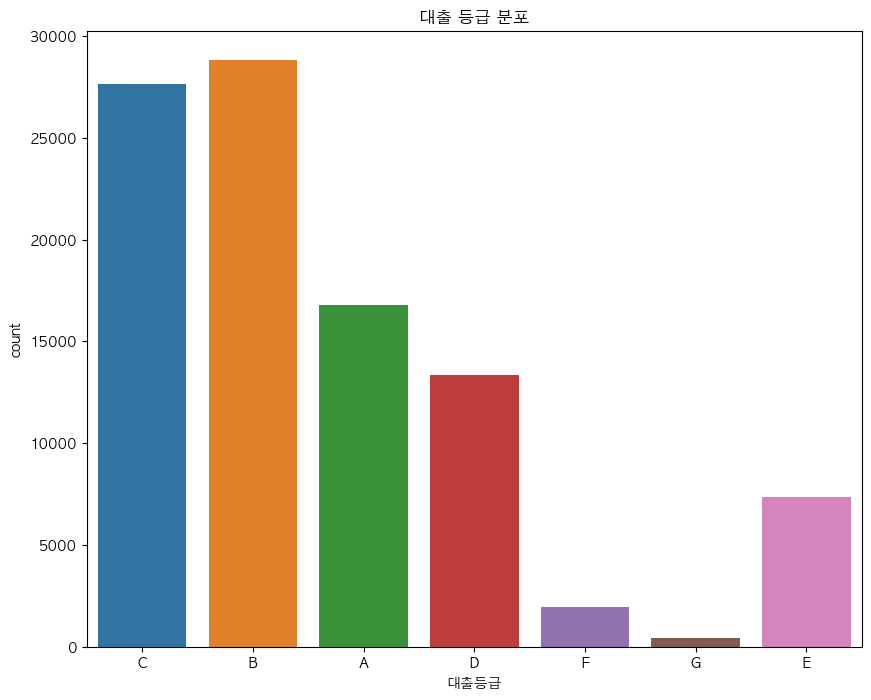

In [8]:
plt.figure(figsize=(10,8))
sns.countplot(x='대출등급',data=data)

plt.title('대출 등급 분포')
plt.show()

# 대출 등급을 분류하는 문제. y값이 뭔지 파악해야지
# 대출 등급에 대해 plot 해봄.

# F & G 등급은 학습부족으로 인해 못 맞출 확률이 크다.

# 데이터 전처리

In [10]:
data.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


- 대출기간, 근로기간 : 뒤에 str형태만 빼서 숫자만 가져오자.
- 대출소유상태,대출목적, 대출등급 : 라벨링이나 원핫인코딩으로 수치형으로 바꾸자.

In [11]:
data['근로기간']

0          6 years
1        10+ years
2          5 years
3          8 years
4          Unknown
           ...    
96289    10+ years
96290    10+ years
96291       1 year
96292      5 years
96293    10+ years
Name: 근로기간, Length: 96294, dtype: object

In [12]:
# 근로기간 데이터 -> 수치형으로 변환
def convert_employment_length_to_numeric(value):
    if value == 'Unknown': # 결측치가 없었으니 동작 안 할 듯
        return 0
    else: # 숫자만 찾아라
        numeric_value = re.findall('\d+',value)
        if numeric_value: # 0이 아닌 값은 불러내서 0으로 return한다
            return int(numeric_value[0])
        else:
            return 0

In [13]:
data['근로기간'] = data['근로기간'].apply(convert_employment_length_to_numeric)
data['근로기간'] = data['근로기간'].astype(int)
data

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,0,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36 months,10,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,TRAIN_96290,28800000,60 months,10,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,TRAIN_96291,14400000,36 months,1,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,TRAIN_96292,15600000,36 months,5,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [14]:
data['대출기간']

0         36 months
1         60 months
2         36 months
3         36 months
4         60 months
            ...    
96289     36 months
96290     60 months
96291     36 months
96292     36 months
96293     36 months
Name: 대출기간, Length: 96294, dtype: object

In [16]:
data['대출기간'] = data['대출기간'].str.strip()
# 앞뒤의 공백을 제거해줌.
data['대출기간']

0        36 months
1        60 months
2        36 months
3        36 months
4        60 months
           ...    
96289    36 months
96290    60 months
96291    36 months
96292    36 months
96293    36 months
Name: 대출기간, Length: 96294, dtype: object

In [17]:
data['대출기간'].str.split(' ')

0        [36, months]
1        [60, months]
2        [36, months]
3        [36, months]
4        [60, months]
             ...     
96289    [36, months]
96290    [60, months]
96291    [36, months]
96292    [36, months]
96293    [36, months]
Name: 대출기간, Length: 96294, dtype: object

In [18]:
data['대출기간'].str.split(' ',expand=True)

,0,1
0,36,months
1,60,months
2,36,months
3,36,months
4,60,months
...,...,...
96289,36,months
96290,60,months
96291,36,months
96292,36,months


In [19]:
data['대출기간'].str.split(' ',expand=True)[0]

0        36
1        60
2        36
3        36
4        60
         ..
96289    36
96290    60
96291    36
96292    36
96293    36
Name: 0, Length: 96294, dtype: object

In [21]:
data['대출기간'] = data['대출기간'].str.split(' ',expand=True)[0]
data.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36,6,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60,10,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36,5,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36,8,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60,0,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


# 원핫 인코딩으로 범주형 변수 인코딩

In [22]:
data['주택소유상태'].nunique()

4

In [23]:
data['주택소유상태'].unique()
# 높이가 없는 카테고리 값

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

In [24]:
data['대출목적'].nunique()

12

In [25]:
data['대출목적'].unique()

array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)

In [ ]:
'부채 통합', '주택 개선', '주요 구매'|'휴가', '의료', '자동차'|'신용 카드', '소규모 사업','기타', '이사', '주택', '재생 에너지'

# unique 데이터값을 줄여라. 몇 개 까지 줄이냐 정석은 없고 case by case

In [26]:
categorical_features = ['주택소유상태','대출목적']
data = pd.get_dummies(data,columns=categorical_features,drop_first=True)
data

,ID,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,TRAIN_00000,12480000,36,6,72000000,18.90,15,0,0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,TRAIN_00001,14400000,60,10,130800000,22.33,21,0,373572,234060.0,...,False,False,False,False,False,False,False,False,True,False
2,TRAIN_00002,12000000,36,5,96000000,8.60,14,0,928644,151944.0,...,False,False,False,False,False,False,False,False,False,False
3,TRAIN_00003,14400000,36,8,132000000,15.09,15,0,325824,153108.0,...,False,False,False,False,False,False,False,False,False,False
4,TRAIN_00004,18000000,60,0,71736000,25.39,19,0,228540,148956.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36,10,210000000,9.33,33,0,974580,492168.0,...,False,True,False,False,False,False,False,False,False,False
96290,TRAIN_96290,28800000,60,10,132000000,5.16,25,0,583728,855084.0,...,False,False,False,False,False,False,False,False,True,False
96291,TRAIN_96291,14400000,36,1,84000000,11.24,22,0,1489128,241236.0,...,False,True,False,False,False,False,False,False,False,False
96292,TRAIN_96292,15600000,36,5,66330000,17.30,21,2,1378368,818076.0,...,False,False,False,False,False,False,False,False,False,False


# 라벨 인코딩

In [27]:
data['대출등급']
# 높이가 있는 범주형 데이터
# 0,1,2,3,4,5 로 바꿀 수 있다!

0        C
1        B
2        A
3        C
4        B
        ..
96289    C
96290    E
96291    A
96292    D
96293    C
Name: 대출등급, Length: 96294, dtype: object

In [28]:
data['대출등급'] = LabelEncoder().fit_transform(data['대출등급'])
data

,ID,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,TRAIN_00000,12480000,36,6,72000000,18.90,15,0,0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,TRAIN_00001,14400000,60,10,130800000,22.33,21,0,373572,234060.0,...,False,False,False,False,False,False,False,False,True,False
2,TRAIN_00002,12000000,36,5,96000000,8.60,14,0,928644,151944.0,...,False,False,False,False,False,False,False,False,False,False
3,TRAIN_00003,14400000,36,8,132000000,15.09,15,0,325824,153108.0,...,False,False,False,False,False,False,False,False,False,False
4,TRAIN_00004,18000000,60,0,71736000,25.39,19,0,228540,148956.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36,10,210000000,9.33,33,0,974580,492168.0,...,False,True,False,False,False,False,False,False,False,False
96290,TRAIN_96290,28800000,60,10,132000000,5.16,25,0,583728,855084.0,...,False,False,False,False,False,False,False,False,True,False
96291,TRAIN_96291,14400000,36,1,84000000,11.24,22,0,1489128,241236.0,...,False,True,False,False,False,False,False,False,False,False
96292,TRAIN_96292,15600000,36,5,66330000,17.30,21,2,1378368,818076.0,...,False,False,False,False,False,False,False,False,False,False


In [29]:
data['대출등급'].unique()

array([2, 1, 0, 3, 5, 6, 4])

In [30]:
data['대출등급']

0        2
1        1
2        0
3        2
4        1
        ..
96289    2
96290    4
96291    0
96292    3
96293    2
Name: 대출등급, Length: 96294, dtype: int64

- 0,1,2로 나온 걸 다시 A,B,C로 반환하고자 할 때는
- labeler = LabelEncoder() (객체로 저장)
- data['대출등급'] = labeler.fit_transform(data['대출등급'])
- labeler.transform(data['대출등급'])
- 이 3줄 실행하면 됨.

# 데이터 분할

In [31]:
data
# 필요없는 ID랑 예측해야 할 y값인 대출 등급을 뺀다.

,ID,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,TRAIN_00000,12480000,36,6,72000000,18.90,15,0,0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,TRAIN_00001,14400000,60,10,130800000,22.33,21,0,373572,234060.0,...,False,False,False,False,False,False,False,False,True,False
2,TRAIN_00002,12000000,36,5,96000000,8.60,14,0,928644,151944.0,...,False,False,False,False,False,False,False,False,False,False
3,TRAIN_00003,14400000,36,8,132000000,15.09,15,0,325824,153108.0,...,False,False,False,False,False,False,False,False,False,False
4,TRAIN_00004,18000000,60,0,71736000,25.39,19,0,228540,148956.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36,10,210000000,9.33,33,0,974580,492168.0,...,False,True,False,False,False,False,False,False,False,False
96290,TRAIN_96290,28800000,60,10,132000000,5.16,25,0,583728,855084.0,...,False,False,False,False,False,False,False,False,True,False
96291,TRAIN_96291,14400000,36,1,84000000,11.24,22,0,1489128,241236.0,...,False,True,False,False,False,False,False,False,False,False
96292,TRAIN_96292,15600000,36,5,66330000,17.30,21,2,1378368,818076.0,...,False,False,False,False,False,False,False,False,False,False


In [32]:
X = data.drop(['ID','대출등급'],axis=1)
X

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,12480000,36,6,72000000,18.90,15,0,0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,14400000,60,10,130800000,22.33,21,0,373572,234060.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,12000000,36,5,96000000,8.60,14,0,928644,151944.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,14400000,36,8,132000000,15.09,15,0,325824,153108.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,18000000,60,0,71736000,25.39,19,0,228540,148956.0,0.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36,10,210000000,9.33,33,0,974580,492168.0,0.0,...,False,True,False,False,False,False,False,False,False,False
96290,28800000,60,10,132000000,5.16,25,0,583728,855084.0,0.0,...,False,False,False,False,False,False,False,False,True,False
96291,14400000,36,1,84000000,11.24,22,0,1489128,241236.0,0.0,...,False,True,False,False,False,False,False,False,False,False
96292,15600000,36,5,66330000,17.30,21,2,1378368,818076.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [35]:
X = X.astype(int)
X

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,12480000,36,6,72000000,18,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14400000,60,10,130800000,22,21,0,373572,234060,0,...,0,0,0,0,0,0,0,0,1,0
2,12000000,36,5,96000000,8,14,0,928644,151944,0,...,0,0,0,0,0,0,0,0,0,0
3,14400000,36,8,132000000,15,15,0,325824,153108,0,...,0,0,0,0,0,0,0,0,0,0
4,18000000,60,0,71736000,25,19,0,228540,148956,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36,10,210000000,9,33,0,974580,492168,0,...,0,1,0,0,0,0,0,0,0,0
96290,28800000,60,10,132000000,5,25,0,583728,855084,0,...,0,0,0,0,0,0,0,0,1,0
96291,14400000,36,1,84000000,11,22,0,1489128,241236,0,...,0,1,0,0,0,0,0,0,0,0
96292,15600000,36,5,66330000,17,21,2,1378368,818076,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
y = data['대출등급']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# 과적합을 방지하기 위해 train, test 나누는 것!!!
# train, test, validation으로 나누면 더 과적합을 방지할 수 있지..
# K-fold 까지 적용하면 좋음~

# XGBoost로 모델링

In [37]:
model = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')
model.fit(X_train,y_train)
# 모델들이 학습된 것

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

# 모델 평가하기

In [38]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
conf_matrix = confusion_matrix(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred,average='macro')

print(f"정확도: {accuracy}")
print(f"혼동 행렬:\n{conf_matrix}")
print(f"정밀도: {precision}")
print(f"재현율: {recall}")
print(f"F1 점수: {f1}")

# 정확성을 좀 더 높이기 위해 전처리를 다르게 해보는 것.
# 이상치를 제거하기, 추가적인 데이터 끌고오기 등등..

정확도: 0.8468248611038994
혼동 행렬:
[[2846  396   29    0    0    0    0]
 [ 288 5070  432   13    3    1    0]
 [  30  403 4838  202   19    2    0]
 [  13   69  308 2190  152    8    2]
 [   1   14   53  290 1048   39    3]
 [   0    5   19   13   84  280   16]
 [   0    0    3    3    5   32   37]]
정밀도: 0.8023876499836569
재현율: 0.7543083377223576
F1 점수: 0.7754826219026072


- **정확도(Accuracy)**: 전체 예측 중 올바르게 예측된 비율입니다.
- **정밀도(Precision)**: 양성으로 예측된 사례 중 실제 양성인 사례의 비율입니다.
- **재현율(Recall)**: 실제 양성인 사례 중 양성으로 올바르게 예측된 비율입니다.
- **F1 점수(F1 Score)**: 정밀도와 재현율의 조화 평균입니다. 불균형 데이터셋에서 유용하게 사용됩니다.

# 특성 중요도 시각화
- decision 계열 model들은 feature importance가 찍힌다.
- 모델이 판단하기에 y값을 판단할 때 어떤 컬럼이 중요했는지 알려줌.

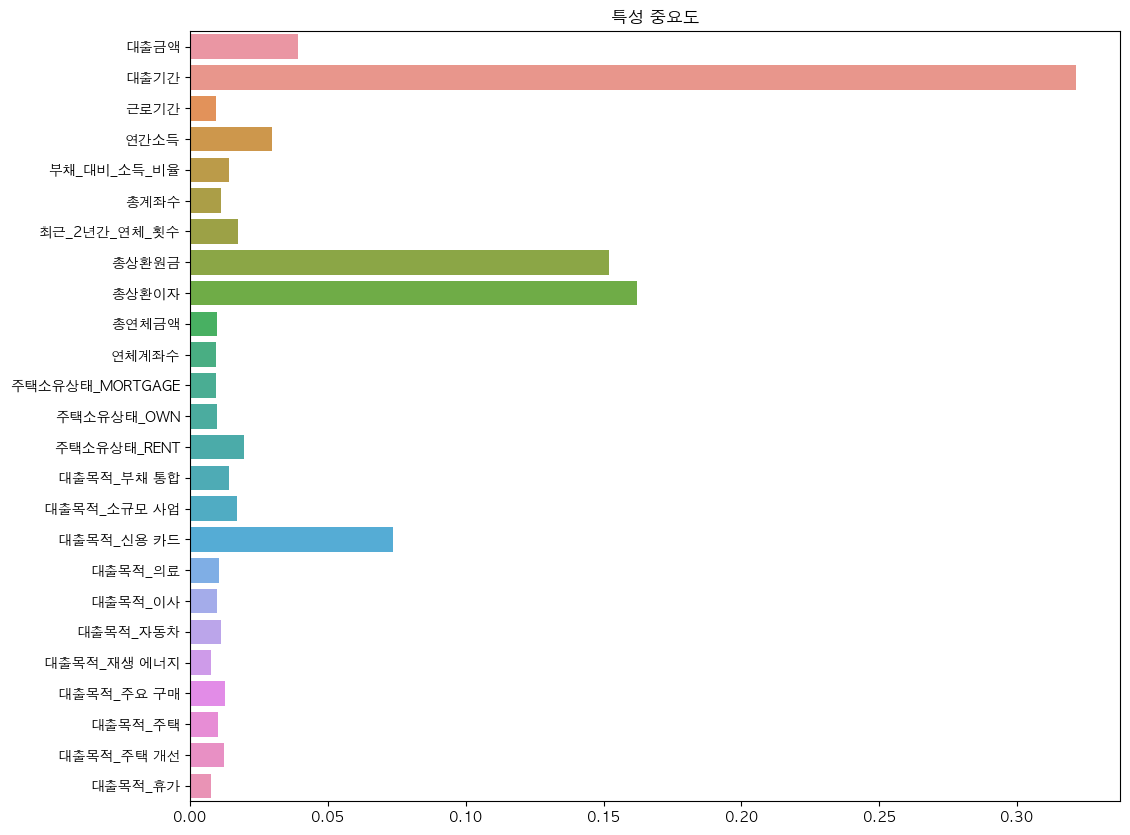

In [39]:
feature_importances = model.feature_importances_

plt.figure(figsize=(12,10))
sns.barplot(x=feature_importances,y=X.columns)
plt.title('특성 중요도')

plt.show()

값의 범위: 각 피처의 중요도는 0과 1 사이의 값을 가집니다.
값이 높을수록 해당 피처가 모델의 결정에 더 큰 영향을 미친다는 것을 의미.

해석: 모델이 피처를 얼마나 "중요하게" 사용했는지를 나타내지만, 
피처의 영향 방향(양의 관계인지 음의 관계인지)이나 복잡한 관계(비선형성 등)를 설명하지는 않습니다.
사용 모델: feature_importances_는 결정 트리(Decision Tree),
 랜덤 포레스트(Random Forest), 그리고 XGBoost와 같은 그래디언트 부스팅 모델 등, 트리 기반 모델에서 제공됩니다.
사용

# 혼동행렬
![confusion](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FmgyPF%2FbtqDkAkjNSL%2FMqUcOIIdnIyP6zK9J5jzF0%2Fimg.png)

- TP (True Positive): 양성으로 올바르게 분류된 경우
- TN (True Negative): 음성으로 올바르게 분류된 경우
- FP (False Positive): 음성인데 양성으로 잘못 분류된 경우 (1종 오류)
- FN (False Negative): 양성인데 음성으로 잘못 분류된 경우 (2종 오류)

- 정확도 (Accuracy) : 전체 샘플 중 올바르게 예측된 샘플의 비율
    - (TP + TN) / (TP + TN + FP + FN)
- 정밀도 (Precision): 양성으로 예측된 샘플 중 실제 양성인 샘플의 비율
    - (TP) / (TP + FP)
- 재현율 (Recall): 실제 양성 샘플 중 양성으로 올바르게 예측된 샘플의 비율
    - (TP) / (TP + FN)
- F1 점수 (F1 Score): 정밀도와 재현율의 조화 평균
    - 2 * (precision * recall) / (precision + recall)